In [33]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

#print(os.listdir('../LSTM'))

In [34]:
data = pd.read_csv('SD-multi-LSTM.csv')
data= data[data['hour']!='dummy']
data['A1']=data['A1'].astype("category")
data['A2']=data['A2'].astype("category")
data['A3']=data['A3'].astype("category")
data['sex']=data['sex'].astype("category")
data['age']=data['age'].astype("category")
data['org']=data['org'].astype("category")
data['weekday']=data['weekday'].astype("category")
data['RMV']=data['RMV'].astype("category")
data['hour']=data['hour'].astype("int")
data['month']=data['month'].astype("int")
data['truth']=data['truth'].astype("category")
data.head()



# #data['truth']=np.where(data['truth'] ==1, 'YY', data['truth'])
# data['truth']=np.where(data['truth'] ==2, '0', data['truth'])
# data['truth']=np.where(data['truth'] =='3', '0', data['truth'])
# data['truth']=np.where(data['truth'] =='4', '0', data['truth'])
# data['truth']=np.where(data['truth'] =='5', '0', data['truth'])

# #data['A1']=np.where(data['A1'] ==1, 'YY', data['A1'])
# data['A1']=np.where(data['A1'] ==2, '0', data['A1'])
# data['A1']=np.where(data['A1'] =='3', '0', data['A1'])
# data['A1']=np.where(data['A1'] =='4', '0', data['A1'])
# data['A1']=np.where(data['A1'] =='5', '0', data['A1'])
# #data['A2']=np.where(data['A2'] ==1, 'YY', data['A2'])
# data['A2']=np.where(data['A2'] ==2, '0', data['A2'])
# data['A2']=np.where(data['A2'] =='3', '0', data['A2'])
# data['A2']=np.where(data['A2'] =='4', '0', data['A2'])
# data['A2']=np.where(data['A2'] =='5', '0', data['A2'])
# #data['A3']=np.where(data['A3'] ==1, 'YY', data['A3'])
# data['A3']=np.where(data['A3'] ==2, '0', data['A3'])
# data['A3']=np.where(data['A3'] =='3', '0', data['A3'])
# data['A3']=np.where(data['A3'] =='4', '0', data['A3'])
# data['A3']=np.where(data['A3'] =='5', '0', data['A3'])

data.columns

Index(['A1', 'A2', 'A3', 'hour', 'weekday', 'truth', 'month', 'age', 'sex',
       'org', 'RMV', 'REM', 'RGLAD', 'RLFC', 'text'],
      dtype='object')

In [35]:
data= data[data['truth']!=5]
data= data[data['A1']!=5]
data= data[data['A2']!=5]
data= data[data['A3']!=5]
data= data[data['RMV']!=5]
data= data[data['REM']!=5]
data= data[data['RGLAD']!=5]
data= data[data['RLFC']!=5]

In [36]:

data = pd.get_dummies(data, prefix=['A1', 'A2', 'A3', 'weekday', 'month', 'age', 'sex',
       'org', 'RMV', 'REM', 'RGLAD', 'RLFC'], columns=['A1', 'A2', 'A3', 'weekday', 'month', 'age', 'sex',
       'org', 'RMV', 'REM', 'RGLAD', 'RLFC'], drop_first=False)
data.head()


,hour,truth,text,A1_1,A1_2,A1_3,A1_4,A1_5,A2_1,A2_2,...,REM_3,REM_4,RGLAD_1,RGLAD_2,RGLAD_3,RGLAD_4,RLFC_1,RLFC_2,RLFC_3,RLFC_4
0,22,2,Correct same as inverson no practice sleep giv...,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,12,2,i get great sleeps outside on june 18th or aro...,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
2,12,4,Justin if i could sleep 20 hours and remember ...,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,20,4,There is a disease where you eventually stop s...,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,2,4,i might be edgy saving extra pills for girlfri...,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [37]:
data.columns

Index(['hour', 'truth', 'text', 'A1_1', 'A1_2', 'A1_3', 'A1_4', 'A1_5', 'A2_1',
       'A2_2', 'A2_3', 'A2_4', 'A2_5', 'A3_1', 'A3_2', 'A3_3', 'A3_4', 'A3_5',
       'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'age_19-29', 'age_30-39',
       'age_<=18', 'age_>=40', 'sex_female', 'sex_male', 'org_is-org',
       'org_non-org', 'RMV_1', 'RMV_2', 'RMV_3', 'RMV_4', 'RMV_5', 'REM_1',
       'REM_2', 'REM_3', 'REM_4', 'RGLAD_1', 'RGLAD_2', 'RGLAD_3', 'RGLAD_4',
       'RLFC_1', 'RLFC_2', 'RLFC_3', 'RLFC_4'],
      dtype='object')

In [38]:
X = data.drop('truth', axis=1)

y = data['truth']

In [39]:
from sklearn import preprocessing
from keras.utils import np_utils
from keras.utils import to_categorical

# label_encoder object knows how to understand word labels.
# label_encoder = preprocessing.LabelEncoder()

# # Encode labels in column 'species'.
# y = label_encoder.fit_transform(y)
# encode class values as integers
# encoder = LabelEncoder()
# encoder.fit(y)
# encoded_Y = encoder.transform(y)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y = np_utils.to_categorical(encoded_Y)

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


# make the model and load the training dataset.

#y_train = to_categorical(y_train)

In [40]:
y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [41]:
dic = {"`":"'", "’":"'", "‘":"'", "´":"'","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                       "It's": 'It is', "Can't": 'Can not', "I've": 'I have', "\n":" ", "—":"", ".":"", "…":"", "!":"", ":":" ",
                       "-":" ","•":""}

#"😍":"lovely" 

In [42]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    for i, j in dic.items():
        sentence = sentence.lower().replace(i, j)
    sentence = re.sub(r"http[s]?://t.co/[A-Za-z0-9]*"," ",sentence) #URLs

    return sentence

In [43]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

In [44]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 27

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

In [46]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

# glove_file = open('glove.twitter.27B.200d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary[word] = vector_dimensions

# glove_file.close()

embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [47]:
X.columns

Index(['hour', 'text', 'A1_1', 'A1_2', 'A1_3', 'A1_4', 'A1_5', 'A2_1', 'A2_2',
       'A2_3', 'A2_4', 'A2_5', 'A3_1', 'A3_2', 'A3_3', 'A3_4', 'A3_5',
       'weekday_Fri', 'weekday_Mon', 'weekday_Sat', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'age_19-29', 'age_30-39',
       'age_<=18', 'age_>=40', 'sex_female', 'sex_male', 'org_is-org',
       'org_non-org', 'RMV_1', 'RMV_2', 'RMV_3', 'RMV_4', 'RMV_5', 'REM_1',
       'REM_2', 'REM_3', 'REM_4', 'RGLAD_1', 'RGLAD_2', 'RGLAD_3', 'RGLAD_4',
       'RLFC_1', 'RLFC_2', 'RLFC_3', 'RLFC_4'],
      dtype='object')

In [48]:
X2_train = X_train[['hour', 'A1_1', 'A1_2', 'A1_3', 'A1_4', 'A1_5', 'A2_1', 'A2_2',
       'A2_3', 'A2_4', 'A2_5', 'A3_1', 'A3_2', 'A3_3', 'A3_4', 'A3_5',
       'RMV_1', 'RMV_2', 'RMV_3', 'RMV_4', 'RMV_5', 'REM_1',
       'REM_2', 'REM_3', 'REM_4', 'RGLAD_1', 'RGLAD_2', 'RGLAD_3', 'RGLAD_4',
       'RLFC_1', 'RLFC_2', 'RLFC_3', 'RLFC_4']].values
X2_test = X_test[['hour', 'A1_1', 'A1_2', 'A1_3', 'A1_4', 'A1_5', 'A2_1', 'A2_2',
       'A2_3', 'A2_4', 'A2_5', 'A3_1', 'A3_2', 'A3_3', 'A3_4', 'A3_5',
       'RMV_1', 'RMV_2', 'RMV_3', 'RMV_4', 'RMV_5', 'REM_1',
       'REM_2', 'REM_3', 'REM_4', 'RGLAD_1', 'RGLAD_2', 'RGLAD_3', 'RGLAD_4',
       'RLFC_1', 'RLFC_2', 'RLFC_3', 'RLFC_4']].values

ncols=X2_train.shape[1]

In [49]:
ncols

33

In [50]:
from keras.layers import Input
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(ncols,))

In [51]:
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(input_1)
#LSTM_Layer_1 = Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25))(embedding_layer)
LSTM_Layer_1 = LSTM(128, dropout=0.25, recurrent_dropout=0.25)(embedding_layer)
LSTM_Layer_2 = Dense(64, activation='relu')(LSTM_Layer_1)

In [52]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)

In [53]:
from keras.layers import concatenate
from keras.models import Model
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D

concat_layer = concatenate([LSTM_Layer_2, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(4, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

In [54]:
from keras import backend as K
import tensorflow as tf
from sklearn.metrics import roc_auc_score


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)




model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', f1_m,precision_m, recall_m])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 27)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 27, 200)      539400      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          168448      embedding[0][0]                  
_______________________________________________________________________________________

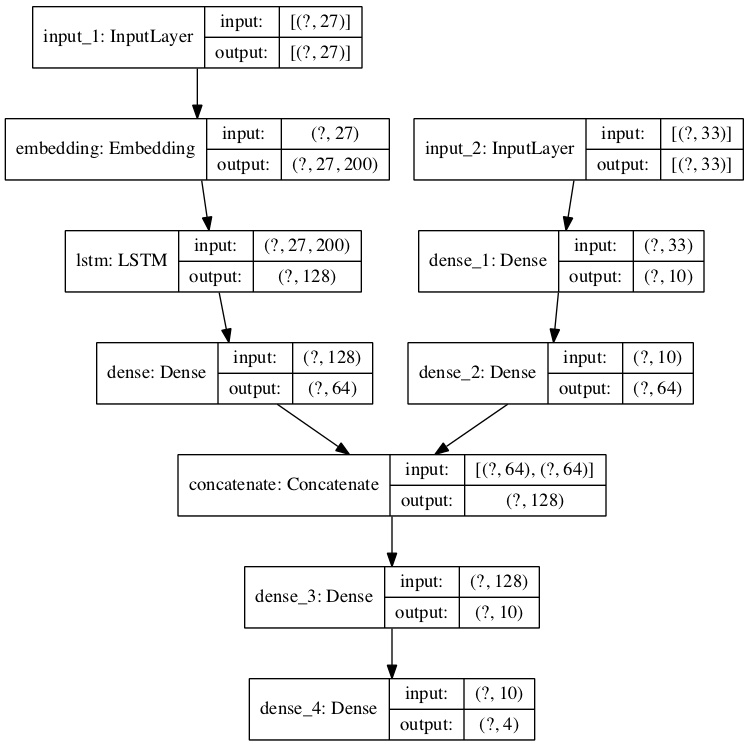

In [55]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [56]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
4/4 [==============================] - 1s 167ms/step - loss: 1.3577 - acc: 0.3988 - f1_m: 0.2012 - precision_m: 0.3702 - recall_m: 0.1404 - val_loss: 1.3367 - val_acc: 0.3889 - val_f1_m: 0.1081 - val_precision_m: 0.3636 - val_recall_m: 0.0635
Epoch 2/50
4/4 [==============================] - 0s 83ms/step - loss: 1.2949 - acc: 0.4544 - f1_m: 0.1316 - precision_m: 0.5882 - recall_m: 0.0755 - val_loss: 1.3020 - val_acc: 0.4365 - val_f1_m: 0.0156 - val_precision_m: 0.5000 - val_recall_m: 0.0079
Epoch 3/50
4/4 [==============================] - 0s 87ms/step - loss: 1.2676 - acc: 0.5040 - f1_m: 0.0709 - precision_m: 0.7540 - recall_m: 0.0374 - val_loss: 1.2757 - val_acc: 0.4365 - val_f1_m: 0.0157 - val_precision_m: 1.0000 - val_recall_m: 0.0079
Epoch 4/50
4/4 [==============================] - 0s 76ms/step - loss: 1.2425 - acc: 0.5179 - f1_m: 0.0532 - precision_m: 0.7542 - recall_m: 0.0277 - val_loss: 1.2507 - val_acc: 0.4365 - val_f1_m: 0.0157 - val_precision_m: 1.0000 - val_reca

In [57]:
loss, accuracy, f1_score, precision, recall  = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)



9/9 [==============================] - 0s 6ms/step - loss: 0.6473 - acc: 0.7601 - f1_m: 0.7595 - precision_m: 0.8094 - recall_m: 0.7164


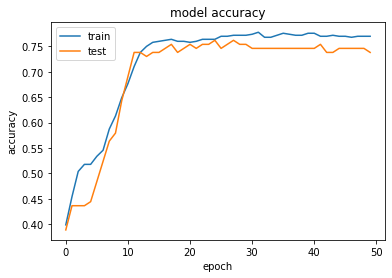

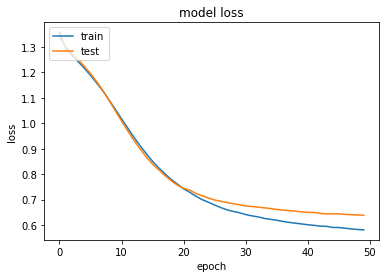

In [58]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment


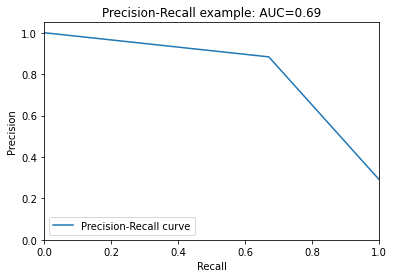

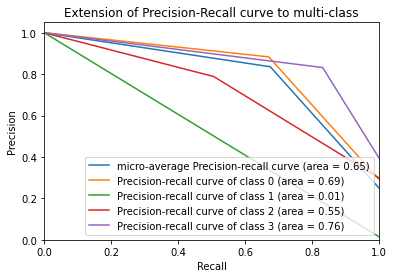

In [59]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

predictions = model.predict([X1_test, X2_test])
y_pred = (predictions > 0.6)
y_test = label_binarize(y_test, classes=['YY','YN','NY','NN'])
y_pred = label_binarize(y_pred, classes=['YY','YN','NY','NN'])
n_classes = 4



# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])
    

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")

  
# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i in range(n_classes):
    plt.plot(recall[i], precision[i],
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

In [60]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

NameError: name 'metrics' is not defined

In [ ]:
import shap

explainer = shap.DeepExplainer(model, X1_train[:100])
shap_values = explainer.shap_values(X1_test[:10])

In [ ]:
f=shap.force_plot(explainer.expected_value, shap_values, X, show=False)
shap.save_html("index.htm", f)

In [ ]:
auc_score

In [ ]:
from matplotlib import colors as plt_colors
import numpy as np
import shap
import matplotlib.pyplot as pl




shap.summary_plot(shap_values, X, show=False)

pl.savefig("ranks.pdf", dpi=800,  bbox_inches = 'tight')
pl.show()

-------------------------------------------


In [ ]:
from cleanlab.latent_estimation import estimate_cv_predicted_probabilities
import cleanlab


s = np.array(y)

probabilities = estimate_cv_predicted_probabilities(
    X, 
    s, 
    clf=model,
)
psx = cleanlab.latent_estimation.estimate_cv_predicted_probabilities(
    X, s, clf=model)

In [ ]:
import pandas as pd
import numpy as np
df=data

In [ ]:
for tweet, label in df.sample(10)[["text", "result"]].values:
    print(label, tweet)

In [ ]:
import tensorflow_hub as hub

# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/4")

In [ ]:
X_train_embeddings = embed(df.text.values)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

logistic_clf = RandomForestClassifier(n_estimators=100, max_depth= 30, max_features=.75, criterion='entropy', min_samples_split=15, class_weight='balanced')

In [ ]:
logistic_clf.fit(X_train_embeddings['outputs'][:3000,:],
                 df.result.values[:3000])

In [ ]:
RandomForestClassifier(n_estimators=100, max_depth= 30, max_features=.75, criterion='entropy', min_samples_split=15, class_weight='balanced')

In [ ]:

y_pred = logistic_clf.predict(X_train_embeddings['outputs'][3000:,:])
y_pred_proba = logistic_clf.predict_proba(X_train_embeddings['outputs'][3000:,:])
print("Accuracy: {:.1%}".format(accuracy_score(df.result.values[3000:], y_pred)))
print("F1: {:.1%}".format(f1_score(df.result.values[3000:], y_pred)))

In [ ]:
from cleanlab.pruning import get_noise_indices

ordered_label_errors = get_noise_indices(
    s=df.result.values[3000:],
    psx=y_pred_proba,
    sorted_index_method='normalized_margin', # Orders label errors
 )

In [ ]:

print("We found {} label errors.".format(len(ordered_label_errors)))

In [ ]:
ordered_label_errors

In [ ]:
df.loc[220]

In [ ]:
error_df = df.loc[df.index[3000:]].loc[df.index[3000+ordered_label_errors]]
for tweet, label in error_df[[ "text", "result"]][:30].values:
    print(label, tweet)